# Question 2: Julia Set, Area, and Fractal Dimension

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from skimage import measure
from scipy.optimize import curve_fit

**Part a) Julia Set Generation**

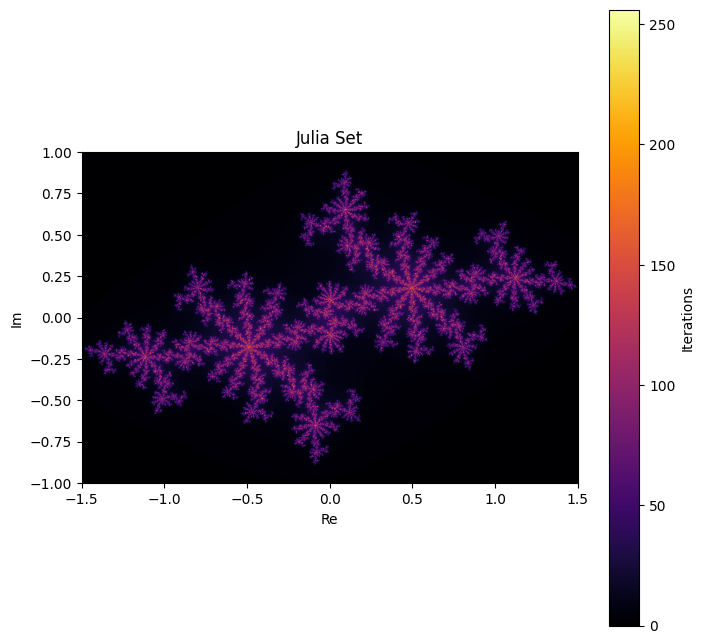

In [13]:
# Define parameters
width, height = 800, 800  # Density
xmin, xmax = -1.5, 1.5
ymin, ymax = -1, 1
c = complex(-0.7, 0.356)  # Julia set constant
max_iter = 256  # Maximum iterations

# Generate the grid
x = np.linspace(xmin, xmax, width)
y = np.linspace(ymin, ymax, height)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Julia set iteration
def julia_iteration(z, c, max_iter):
    iteration_count = np.zeros(z.shape, dtype=int)
    mask = np.ones(z.shape, dtype=bool)
    
    for i in range(max_iter):
        Z[mask] = Z[mask] ** 2 + c
        mask = np.abs(Z) < 2
        iteration_count += mask
    
    return iteration_count

julia_set = julia_iteration(Z, c, max_iter)

# Plot the Julia set
plt.figure(figsize=(8, 8))
plt.imshow(julia_set, extent=[xmin, xmax, ymin, ymax], cmap='inferno')
plt.colorbar(label='Iterations')
plt.title('Julia Set')
plt.xlabel('Re')
plt.ylabel('Im')
# plt.savefig('julia_set.png')
plt.show()

**Part b) Convex Hull**

Convex Hull Area: 2.8025050086074423


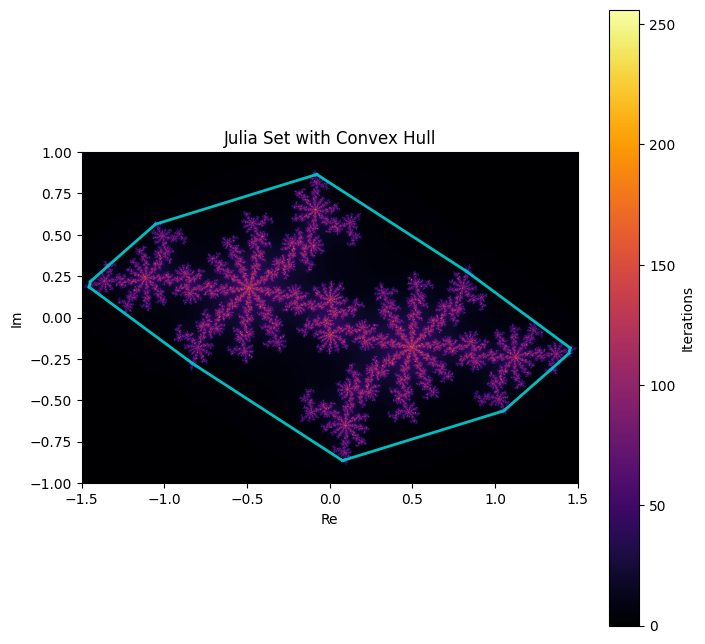

In [ ]:
# Generate the grid
x = np.linspace(xmin, xmax, width)
y = np.linspace(ymin, ymax, height)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Julia set iteration
def julia_iteration(z, c, max_iter):
    iteration_count = np.zeros(z.shape, dtype=int)
    mask = np.ones(z.shape, dtype=bool)
    
    for i in range(max_iter):
        Z[mask] = Z[mask] ** 2 + c
        mask = np.abs(Z) < 2
        iteration_count += mask
    
    return iteration_count

julia_set = julia_iteration(Z, c, max_iter)

# Extract boundary points of the Julia set
threshold = max_iter * 0.75  # Lower threshold to capture more boundary points
points = np.column_stack((X[julia_set > threshold].flatten(), Y[julia_set > threshold].flatten()))

# Flip Y-coordinates to match imshow's orientation
points[:, 1] = -points[:, 1]

# Ensure extreme left/right points are included
if len(points) > 2:
    leftmost = points[np.argmin(points[:, 0])]
    rightmost = points[np.argmax(points[:, 0])]
    points = np.vstack([points, leftmost, rightmost])

    # Compute convex hull
    hull = ConvexHull(points)
    hull_area = hull.volume  # Area of the convex hull
    print(f"Convex Hull Area: {hull_area}")

    # Plot the Julia set with convex hull
    plt.figure(figsize=(8, 8))
    plt.imshow(julia_set, extent=[xmin, xmax, ymin, ymax], cmap='inferno', origin='lower')
    plt.colorbar(label='Iterations')
    plt.title('Julia Set with Convex Hull')
    plt.xlabel('Re')
    plt.ylabel('Im')

    # Draw the convex hull
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], -points[simplex, 1], 'c-', linewidth=2)

    # plt.savefig('julia_set_convex_hull.png')
    plt.show()
else:
    print("Not enough boundary points to compute the convex hull.")

**Part c) Contour**

Enclosed Area of the convex hull of contour points: 2.71815546553286


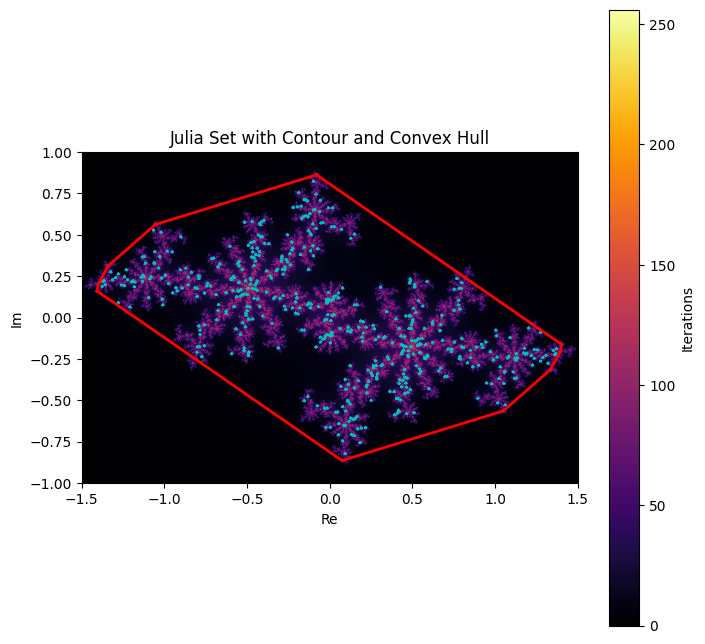

In [29]:
# Extract contour of the Julia set
contours = measure.find_contours(julia_set, level=max_iter * 0.9)

# Store all contour points
all_contour_points = []

for contour in contours:
    x_vals = contour[:, 1] * (xmax - xmin) / width + xmin
    y_vals = contour[:, 0] * (ymax - ymin) / height + ymin
    all_contour_points.extend(np.column_stack((x_vals, y_vals)))

# Convert contour points to a NumPy array
all_contour_points = np.array(all_contour_points)

# Compute convex hull if there are enough points
if len(all_contour_points) > 2:
    hull = ConvexHull(all_contour_points)
    hull_area = hull.volume  # Correct enclosed area calculation
    print(f"Enclosed Area of the convex hull of contour points: {hull_area}")
else:
    hull = None
    hull_area = 0
    print("Not enough points to compute the convex hull.")

# Plot the Julia set with contour and convex hull
plt.figure(figsize=(8, 8))
plt.imshow(julia_set, extent=[xmin, xmax, ymin, ymax], cmap='inferno', origin='lower')
plt.colorbar(label='Iterations')
plt.title('Julia Set with Contour and Convex Hull')
plt.xlabel('Re')
plt.ylabel('Im')

# Draw the contour
for contour in contours:
    plt.plot(contour[:, 1] * (xmax - xmin) / width + xmin, 
             contour[:, 0] * (ymax - ymin) / height + ymin, 'c-', linewidth=2, label='Contour')

# Draw the convex hull
if hull is not None:
    for simplex in hull.simplices:
        plt.plot(all_contour_points[simplex, 0], all_contour_points[simplex, 1], 'r-', linewidth=2, label='Convex Hull')

# plt.savefig('julia_set_contour.png')
plt.show()

**Part d) Box-Counting Method**

In [45]:
# Box-counting method to estimate fractal dimension
# def box_counting(binary_image, sizes):
#     counts = []
#     for size in sizes:
#         S = binary_image.shape[0] // size
#         grid = binary_image[:S*size, :S*size].reshape(S, size, S, size)
#         count = np.count_nonzero(grid.sum(axis=(1, 3)))
#         counts.append(count)
#     return counts

# sizes = np.logspace(1, np.log2(width//4), num=10, base=2, dtype=int)
# binary_image = julia_set > (max_iter * 0.9)
# counts = box_counting(binary_image, sizes)

# coeffs = np.polyfit(np.log(1 / sizes), np.log(counts), 1)
# frac_dim = -coeffs[0]
# print(f"Estimated Fractal Dimension: {frac_dim}")

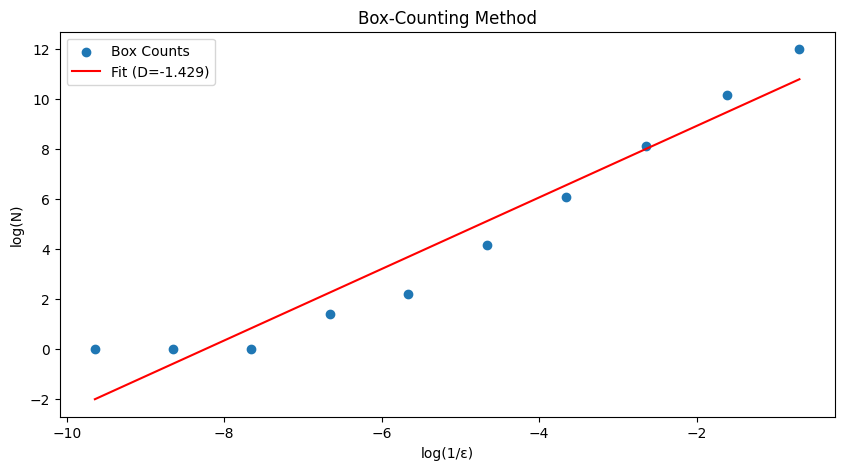

Estimated fractal dimension: 1.429


In [ ]:
# Convert to binary: 1 for points inside the set, 0 for escapees
binary_julia = julia_set < max_iter

# Function to compute box-counting dimension
def box_counting(binary_image):
    sizes = np.logspace(1, np.log2(min(width, height)) / np.log(2), num=10, base=2, dtype=int)
    counts = []

    for size in sizes:
        num_boxes = np.ceil(width / size) * np.ceil(height / size)
        covered = 0

        for i in range(0, width, size):
            for j in range(0, height, size):
                if np.any(binary_image[i:i+size, j:j+size]):
                    covered += 1

        counts.append(covered)

    log_sizes = np.log(1 / sizes)
    log_counts = np.log(counts)

    # Fit line to log-log plot
    def linear_fit(x, a, b):
        return a * x + b

    popt, _ = curve_fit(linear_fit, log_sizes, log_counts)
    fractal_dim = -popt[0]
    
    return fractal_dim, log_sizes, log_counts

# Compute fractal dimension
fractal_dim, log_sizes, log_counts = box_counting(binary_julia)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(log_sizes, log_counts, label="Box Counts")
plt.plot(log_sizes, np.poly1d(np.polyfit(log_sizes, log_counts, 1))(log_sizes), 'r-', label=f"Fit (D={fractal_dim:.3f})")
plt.xlabel("log(1/ε)")
plt.ylabel("log(N)")
plt.title("Box-Counting Method")
plt.legend()
# plt.savefig('julia_set_box_counting.png')
plt.show()

print(f"Estimated fractal dimension: {np.abs(fractal_dim):.3f}")